In [3]:
import os
import time
import copy
import requests
import flickrapi
import numpy as np
import pandas as pd
import geopandas as gpd
import contextily as cx
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from alphashape import alphashape
from sklearn.cluster import DBSCAN
from scipy.spatial.distance import euclidean
from sklearn.feature_extraction.text import TfidfVectorizer

# Places of Intrest - In-Class activity
This notebook reproduces the workflow from the paper:

"Extracting and understanding urban areas of interest using geotagged photos" by Hu et al. 2015

### First: Get Data via Flickr

In [4]:
# Set up API key and secret
api_key = os.getenv('FLICKER_API')
api_secret = os.getenv('FLICKER_API_SECRET')

overview_area = gpd.read_file(r"data\bezirke.shp").dissolve()

In [5]:
# Define bounding box coordinates
bbox = str(overview_area.geometry.bounds.loc[0].tolist())[1:-1].replace(" ", "")

In [6]:
# Set up Flickr API
flickr = flickrapi.FlickrAPI(api_key, api_secret, format='parsed-json')

# Define search parameters
extras = 'geo, license, views, machine_tags, date_taken, date_upload, url_m, tags'
min_upload_date = 1651442400 # 01.05.2022, appr. 1 year

per_page = 250
pages = 25

### Send request only once and save it afterwards

In [7]:
# full_dict_list = []
# photos_raw_list = []

# for page in range(pages):
#     try:
#         photos = flickr.photos.search(bbox=bbox, extras=extras, per_page=per_page, page=page, min_upload_date=min_upload_date)
#         photos_raw_list.append(photos)
#     except:
#         print(f"EXCEPTION ON PAGE {page}")
    
#     photo_dict = photos['photos']['photo']
    
#     full_dict_list.extend(photo_dict)
    
#     if page % 100 == 0:
#         print("Current Page:", page)
#     time.sleep(0.1)

# full_dict = {elem['id']: elem for elem in full_dict_list}
# df = pd.DataFrame(full_dict).T

# df.dateupload = pd.to_datetime(df.dateupload, unit='s')

# full_dict = {elem['id']: elem for elem in full_dict_list}
# df = pd.DataFrame(full_dict).T
# df.dateupload = pd.to_datetime(df.dateupload, unit='s')

In [8]:
# df.to_csv("data/df_new.csv")

In [9]:
df = pd.read_csv("data/df_new.csv")

### Overview

In [10]:
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs=4326)
gdf = gdf.to_crs(32633)
# gdf

In [11]:
overview_area = overview_area.to_crs(32633)

(586393.3811682146, 618804.6838465561, 5329140.523554921, 5354279.871726276)

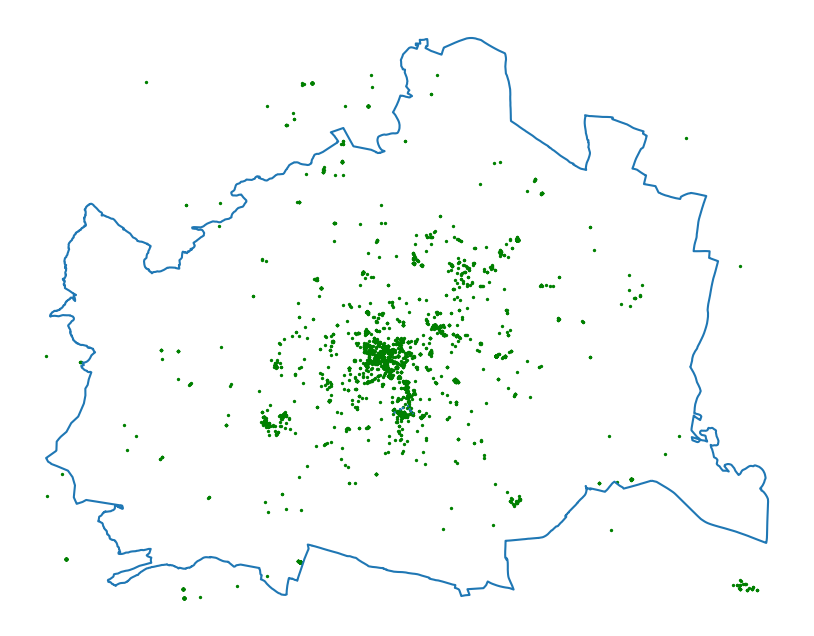

In [12]:
fig, ax = plt.subplots(1, figsize=(12,8))
overview_area.boundary.plot(ax=ax)
gdf.plot(ax=ax, markersize=2, color='green')
plt.axis('off')

In [13]:
gdf['latitude'] = gdf.geometry.y
gdf['longitude'] = gdf.geometry.x

### Remove Users in Neighborhood radius

In [14]:
def filter_duplicates(df, radius):
    filtered_df = pd.DataFrame(columns=df.columns)
    processed_users = set()

    for index, row in df.iterrows():
        owner = row['owner']
        
        #print(row['longitude'])
        x1, y1 = row['longitude'], row['latitude']

        if owner not in processed_users:
            filtered_df = filtered_df.append(row)
            processed_users.add(owner)

        else:
            existing_photos = filtered_df[filtered_df['owner'] == owner]
            existing_coords = [(photo['longitude'], photo['latitude']) for _, photo in existing_photos.iterrows()]
            new_coords = [(x1, y1)]
            distances = [euclidean(new_coord, existing_coord) for new_coord in new_coords for existing_coord in existing_coords]

            if all(distance > radius for distance in distances):
                filtered_df = filtered_df.append(row)
    
    return filtered_df


neighborhood_radius = 200
filtered_df = filter_duplicates(gdf, neighborhood_radius)

filtered_df = gpd.GeoDataFrame(filtered_df, geometry='geometry')

### Get clusters with parameters form paper
We adjust the min_samples to a lower number to get better clusters, using 0.02*len(filtered_df) only gives two clusters

In [15]:
mins = 0.02*len(filtered_df)
coordinates = filtered_df[['latitude', 'longitude']]

# Anwenden des DBSCAN-Algorithmus
dbscan = DBSCAN(eps=200, min_samples=8) 
dbscan.fit(coordinates)
cluster_labels = dbscan.labels_
filtered_df['cluster'] = cluster_labels

In [16]:
filtered_df_clusters = filtered_df[filtered_df.cluster != -1]

<AxesSubplot:>

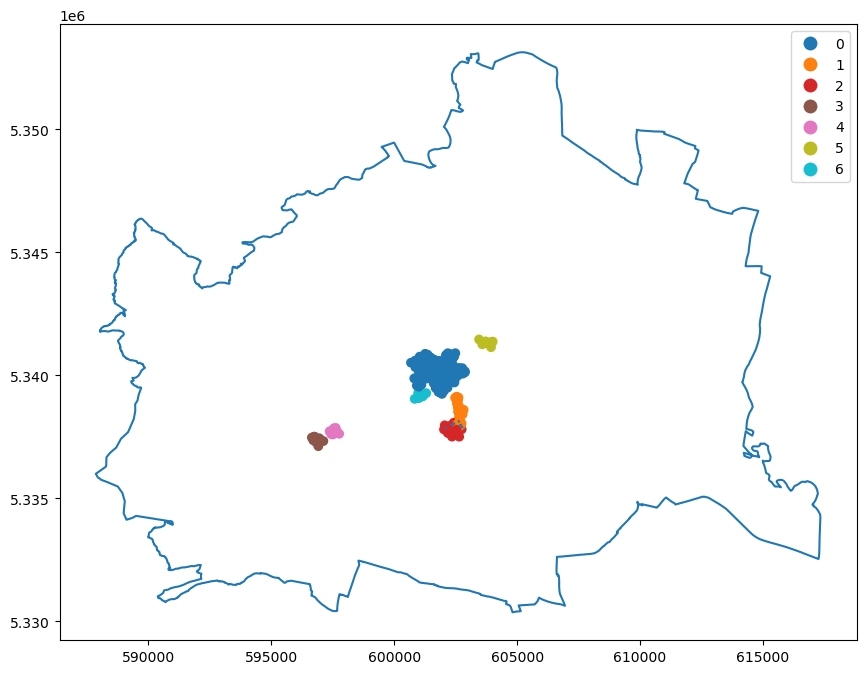

In [17]:
fig, ax = plt.subplots(1, figsize=(12,8))
overview_area.boundary.plot(ax=ax)
filtered_df_clusters.plot(ax=ax, column='cluster', legend=True, categorical=True)

### Download all pictures
To get good examples for the in-class activity. Also this happends only one time

In [18]:
def download(row):
    url = row.url_m
    try:
        np.isnan(url)
        return
    except:
        response = requests.get(url)

        with open(f"data/imgs2/image_{row.name}_cluster_{row.cluster}_{row.id}.jpg", "wb") as f:
            f.write(response.content)

### Create Hulls
For the lambda values a standart is used, since using 32 does not yield good shapes

In [19]:
%%capture
hulls = []

grouped = filtered_df_clusters.groupby('cluster')
for cluster in filtered_df_clusters.cluster.unique():
    group = grouped.get_group(cluster)
    points = [(y, x) for x, y in zip(group.latitude.values, group.longitude.values)]
    concave_hull = alphashape(points)
    hulls.append(concave_hull)
    

In [20]:
gdf_cluster = gpd.GeoDataFrame(None, geometry=gpd.GeoSeries(hulls), crs=32633).reset_index()#.to_crs(3857)
gdf_cluster = gdf_cluster.to_crs(3857)
gdf_cluster['index'] = gdf_cluster['index'].apply(lambda x: x+1)
#gdf_cluster['index'] = gdf_cluster.index.astype(str)

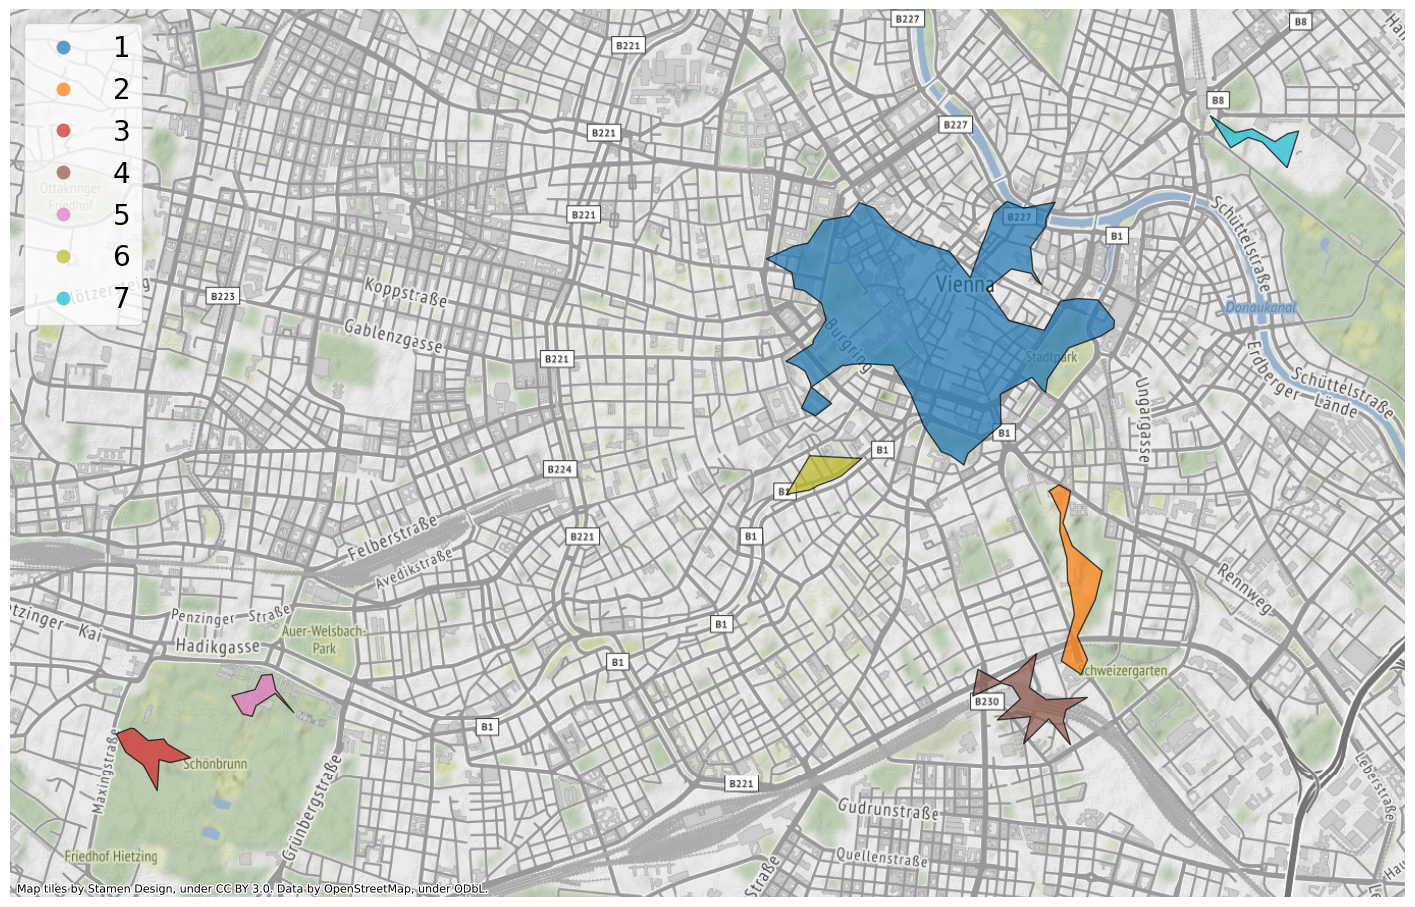

In [21]:
fig, ax = plt.subplots(1, figsize=(18,12))
xlims = gdf_cluster.geometry.total_bounds[0]-1000, gdf_cluster.geometry.total_bounds[2]+1000
ylims = gdf_cluster.geometry.total_bounds[1]-1000, gdf_cluster.geometry.total_bounds[3]+1000
ax.set_ylim(ylims)
ax.set_xlim(xlims)

gdf_cluster.plot(ax=ax, column='index', alpha=0.7, legend=True, linewidth=1, edgecolor='black', categorical=True,\
                legend_kwds={'loc': 'upper left', 'fontsize': 20})
ax.axis('off')
cx.add_basemap(ax)

fig.savefig("maps/all_clusters.png", dpi=350)

In [22]:
gdfs = [gdf_cluster] * 7
gdfs2 = []
for i, gdf in enumerate(gdfs):
    
    gdf['test'] = gdf['index'] / (i+1)
    gdf['color'] = gdf.test.apply(lambda x: x==1)

    gdfs2.append(copy.deepcopy(gdf))

In [23]:
xlims = gdf_cluster.geometry.total_bounds[0]-1000, gdf_cluster.geometry.total_bounds[2]+1000
ylims = gdf_cluster.geometry.total_bounds[1]-1000, gdf_cluster.geometry.total_bounds[3]+1000

for i, gdf_cluster in enumerate(gdfs2):
    fig, ax = plt.subplots(1, figsize=(18,12))

    unique_colors = gdf['color'].unique()
    color_map = {True: 'green', False: 'black'}  # Add more values and colors as needed

    # Create a custom colormap based on the color map
    cmap = plt.cm.colors.ListedColormap([color_map[color] for color in unique_colors])
    ax.set_ylim(ylims)
    ax.set_xlim(xlims)

    gdf_cluster.plot(ax=ax, column='color', cmap=cmap, alpha=0.7, legend=True, linewidth=1,\
                     edgecolor='black', categorical=True, legend_kwds={'loc': 'upper left', 'fontsize': 20})
    ax.axis('off')

    cx.add_basemap(ax)
    
    fig.savefig(f"maps/map_{i}.png", dpi=350)
    plt.close()

# TF-IDF and create word clouds

In [24]:
clusters_tags = []
for cluster in filtered_df_clusters.cluster.unique():
    group = grouped.get_group(cluster)
    all_tags = ''
    for val in [val for val in group.tags.values.tolist() if not str(val) == 'nan']:
        all_tags += val
        
    clusters_tags.append(all_tags)

In [25]:
split_clusters_tags = [tags.split() for tags in clusters_tags]

vectorizer = TfidfVectorizer()
tag_matrix = vectorizer.fit_transform([' '.join(tags) for tags in split_clusters_tags])
df = (tag_matrix > 0).sum(axis=0)

tags_to_remove = set()
for tag, count in zip(vectorizer.get_feature_names_out(), df.A1):
    if count == len(split_clusters_tags):
        tags_to_remove.add(tag)

modified_clusters_tags = [[tag for tag in tags if tag not in tags_to_remove] for tags in split_clusters_tags]

clouds = []

for i, tags in enumerate(modified_clusters_tags):
    cluster_text = ' '.join(tags)
    
    # remove 'österreich' manually
    cluster_text = cluster_text.replace('österreich', '')
    wordcloud = WordCloud(width=1600, height=800, max_words=100, background_color='white').generate(cluster_text)

    clouds.append(wordcloud)

In [26]:
for i, cloud in enumerate(clouds):
    fig, ax = plt.subplots(1, figsize=(16, 12))
    ax.imshow(cloud, interpolation='bilinear')
    ax.set_xticks([])
    ax.set_yticks([])
    
    fig.savefig(f'clouds/cloud_{i}.png', dpi=300)
    plt.close()
    #ax.show()